In [3]:
#!/usr/bin/env python
#coding: utf-8
'''
@authors: Chronowski Amaury, Deleule Alix

Projet de Data Mining
'''

'\n@authors: Chronowski Amaury, Deleule Alix\n\nProjet de Data Mining\n'

# Téléchargement d'images

In [4]:
import requests
import json
from qwikidata.sparql  import return_sparql_query_results
import os
"""
- Q1075 = couleur
- Q274586 = automobile sport
- Q11796413 = decoration militaire
- Q3314483 = fruit
"""
# Permet detélécharger les images en rensignant le type voulu
def TelechargementImage(themes):
    dir = "images"
    try:
        os.mkdir(dir)
    except FileExistsError:
         pass
    for j,theme in enumerate(themes):
        query_string = """
                SELECT ?item ?pic
                WHERE
                {
                ?item wdt:P31 wd:%s .
                ?item wdt:P18 ?pic
                }LIMIT 100"""%(theme)

        res = return_sparql_query_results(query_string)
        data=res['results']['bindings']
        count = 0
        for i in range(len(data)):
            if count >= 25:
                    break
            # Récupérer l'URL de l'image dans le fichier JSON
            image_url = data[i]["pic"]["value"]
            if image_url.split(".")[-1] != "svg":
                # Télécharger l'image à partir de l'URL
                headers = {'User-Agent': 'Mozilla/5.0'}
                response = requests.get(image_url,headers=headers)
                # Écrire l'image sur le disque
                image_name = "image_"+str(count+25*j)
                with open("images/"+image_name+"."+image_url.split(".")[-1], "wb") as f:
                    f.write(response.content)
                count+=1

themes = ("Q1075","Q274586","Q11796413","Q3314483")
TelechargementImage(themes)         

# Fonctions permettant d'obtenir les couleurs les plus présentes dans une image

In [5]:
from PIL import Image
import numpy as np
from math import sqrt, ceil
from sklearn.cluster import MiniBatchKMeans
import colorsys

# permet d'obtenir les num_colors couleurs les plus présentes dans image_path
def get_colors(image_path, num_colors):
    # Ouvrir l'image avec PIL
    image = Image.open(image_path)

    # Redimensionner l'image pour réduire le temps de traitement
    image = image.resize((300, 300))
    
    # Convertir l'image en un tableau NumPy
    image_array = np.array(image.getdata(), np.uint8)
    
    clusters = MiniBatchKMeans(n_clusters=num_colors, n_init=2)    
    
    #  prise en compte des images noir et blanc(1 canal, là où rbg:3 et rgba:4)
    cp_image_array = []
    if (type(image_array[0])==np.uint8):
        for i,val in enumerate(image_array):
            cp_image_array.append([val,val,val])
        image_array=cp_image_array
        
    clusters.fit(image_array)
    
    colors=[]
    for i in range(num_colors):
        colors.append((ceil(clusters.cluster_centers_[i][0]),
        ceil(clusters.cluster_centers_[i][1]),
        ceil(clusters.cluster_centers_[i][2])))
        
    def rgb_to_name(color):
        r1,g1,b1 = color
        (h1, s1, v1) = colorsys.rgb_to_hsv(r1, g1, b1)
        h1*=360
        v1/=255
        couleurs = {
            "rouge":0,
            "orange":30,
            "jaune":60,
            "vert":90,
            "vert2":150,
            "cyan":180,
            "bleu":210,
            "bleu2":240,
            "violet":270,
            "magenta":300,
            "rose":330,
            "rouge2":360
        }
        if v1<15/100:
            return "noir"
        elif s1<30/100:
            if v1<50/100:
                return "gris"
            else:
                return "blanc"
        else:
            dis = []
            cols = []
            for nameColor in couleurs.keys():
                h2=couleurs[nameColor]
                d= abs(h1-h2)
                dis.append(d)
                cols.append(nameColor)
        returnColor = cols[dis.index(min(dis))]
        if returnColor == "vert2":
            returnColor = "vert"
        elif returnColor == "bleu2":
            returnColor = "bleu"
        elif returnColor == "rouge2":
            returnColor = "rouge"
        return returnColor
            
    # Trouver les noms des couleurs les plus proches pour chaque couleur moyenne
    color_names = []
    for color in colors:
        #print(color,rgb_to_name(color))
        color_names.append(rgb_to_name(color))

    return color_names

# Génération des métadonnées

In [6]:
import os
import pandas as pd
import PIL.Image
from PIL.ExifTags import TAGS

def GenMetadonne(path):
    src = os.listdir(path)
    for im in src:
        if im[0]==".":
            src.remove(im)
    src.sort()
    array = []

    tagsName = {"DateTime":306,"PrintImageMatching":50341,"ResolutionUnit":296,"Make":271,"Model":272,"Software":305,"Orientation":274,"Copyright":33432,"XResolution":282,"YResolution":283}

    # Creation du panda
    for data in src:
        img = PIL.Image.open("images/"+data)
        extension = img.format
        if img.format != "TIFF":
            exif_data = img.getexif()

        date = exif_data.get(tagsName["DateTime"])
        '''# decode bytes 
        if isinstance(d, bytes):
            d = d.decode()'''
            
        w = img.width
        h = img.height
        orientation = 'carre'
        if w>h:
            orientation = 'paysage'
        elif h>w:
            orientation = 'portrait'
        
        make=exif_data.get(tagsName["Make"])
        model=exif_data.get(tagsName["Model"])
        
        if make != None:
            if make[-1]==" ":
                make=make[:-1]
            make=make.upper()
        
        num_colors = 1
        c1 = get_colors("images/"+data, num_colors)
        
        array.append([data, extension, w, h, date, make, model, orientation,c1[0]])

        # changes make(brand) to have the same name when they are "look alike"
        for im in array:
            for br in [val[5] for val in array]:
                if br != None and im[5] != None:
                    if br in im[5]:
                        im[5] = br
                        
    return array, src

path = "images"
array, src = GenMetadonne(path)

# Sauvegarde des données du panda dans un json

In [7]:
def SaveDonne(array):
    dataframe = pd.DataFrame(array, columns=["name", "format", "width", "height", "date", "make", "model", "orientation","couleur"])
    dataframe = dataframe.astype(dtype={"name": "<U20", "format": "<U20", "width": "uint64", "height": "uint64","date": "<U20","make": "<U20", "model": "<U20", "orientation": "<U10","couleur": "<U7"})
    path = 'projet_data.json'
    with open(path, 'w') as outfile:
        outfile.write(dataframe.to_json(orient="index"))

    return path

path_json = SaveDonne(array)

# Création du dataframe à partir du json

In [9]:
def GenPanda(src, path):
    dataframe = pd.read_json(path, orient="index")
    dataframe = dataframe.astype(dtype={"name": "<U20", "format": "<U20", "width": "uint64", "height": "uint64","date": "<U20","make": "<U20", "model": "<U20", "orientation": "<U10","couleur": "<U7"})

    # creation du data frame de préférence
    ret = [0 for i in range(len(src))]
    fav = pd.DataFrame(ret, columns=["favorite"])

    return dataframe, fav

dataframe, fav = GenPanda(src, path_json)
dataframe

,name,format,width,height,date,make,model,orientation,couleur
0,image_0.jpg,JPEG,3072,2304,None,EASTMAN KODAK COMPANY,KODAK P712 ZOOM DIGITAL CAMERA,paysage,gris
1,image_1.jpg,JPEG,1020,673,None,None,None,paysage,rouge
2,image_10.JPG,JPEG,3000,2000,2013:03:12 07:52:31,CANON,Canon EOS 450D,paysage,orange
3,image_11.png,PNG,460,397,None,None,None,paysage,gris
4,image_12.JPG,JPEG,1532,1532,2006:03:01 11:58:25,NIKON,NIKON D200,carre,bleu
...,...,...,...,...,...,...,...,...,...
95,image_95.jpg,JPEG,1600,1200,2012:08:16 12:32:40,"MINOLTA CO., LTD.",DiMAGE Xt,paysage,gris
96,image_96.jpg,JPEG,4000,3000,2012:01:29 17:38:42,FUJIFILM,XF1,paysage,blanc
97,image_97.jpg,JPEG,1064,652,None,None,None,paysage,orange
98,image_98.jpg,JPEG,250,250,None,None,None,carre,blanc


# Recueillement  des intérêts de l'utilisateur

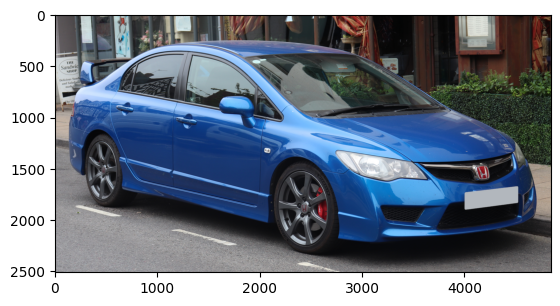

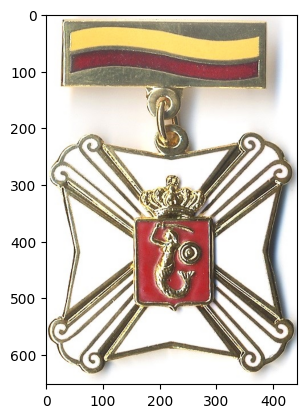

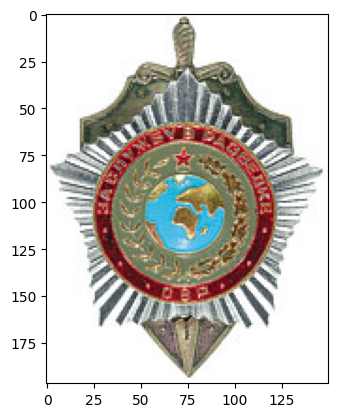

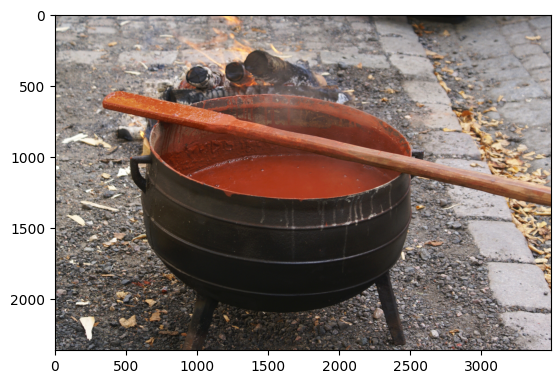

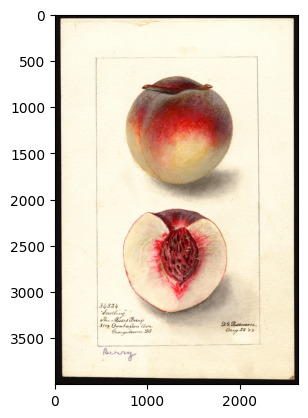

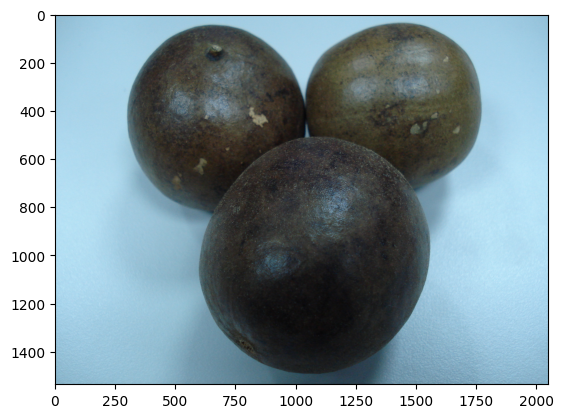

In [10]:
# Librerie
from random import randint
from PIL import Image
import matplotlib.pyplot as plot

# Variables qui donne le nombre d'images qui sera soumis à l'utilisateur.
nb_img_test=6

# Boulce FOR d'affichage d'image aléatoire dans l'echantillon.
for i in range(nb_img_test):
    num_im = randint(0, len(src)-1)
    img = Image.open("images/"+src[num_im]) 

    # Affichage de l'image
    plot.imshow(img)
    plot.show() 

    # Recuillement  des interets de l'utilisateur
    ret = input("Aimez vous cette image ? 1 = oui , 2 = non :")  
    if ret == '1' :
        fav["favorite"][num_im] = 1

# Fonction d'analyse des tags des images aimées

In [14]:
# Fonction permetant de sauvegarder un profil à la suite dans le json
def saveProfile(tagfav):
    file_name = 'profile.json'
    if os.path.exists(file_name):
        df_tagsFavPrev = pd.read_json(file_name,orient="index")
    else:
        df_tagsFavPrev = pd.DataFrame([], columns=["make","orientation","couleur"])
    s=pd.Series(tagfav,index=["make","orientation","couleur"])
    df_tagsFavPrev=df_tagsFavPrev.append(s,ignore_index=True)
    with open(file_name, 'w') as outfile:
        outfile.write(df_tagsFavPrev.to_json(orient="index"))

# Fonction permetant de charger un profil, x le numero du profile dans le json profile.json commençant à 0
def loadProfile(x):
    file_name = 'profile.json'
    df_tagsFav = pd.read_json(file_name,orient="index")
    return list(df_tagsFav.iloc[x])


In [16]:
# Tuples de tags remarquables
makelist_name = list(dataframe["make"].value_counts().nlargest(5).keys())
if "None" in makelist_name:
    makelist_name = list(dataframe["make"].value_counts().nlargest(6).keys())
    makelist_name.remove("None")
orientation_name = ("paysage", "portait", "carre")
col_name = ("rouge", "orange", "jaune", "vert", "cyan", "bleu", "violet", "magenta", "rose", "blanc", "noir", "gris")

# Listes recoltant l'ocurrance des tags
make = [0 for i in range(len(makelist_name))] # Canon, Nikon Corporation, Fujifilm, Sony, Olympus imaging corp, Apple
orientation = [0 for i in range(len(orientation_name))] # Paysage, Portait, Carre
col = [0 for i in range(len(col_name))]  # Rouge, Rouge2, Orange, Jaune, Vert, Vert2, Cyan, Bleu, Bleu2, Violet, Magenta, Rose, Blanc, Noir, Gris

# Boucle For qui aprcoure les images
for i in range(len(src)):

    # Prise en compte des images aimées
    if fav["favorite"][i] == 1:
        
        # Tag make
        for j in range(len(makelist_name)):
            if dataframe["make"][i] == makelist_name[j]:
                make[j] = make[j]+1

        # Tag orientation
        for j in range(len(orientation_name)):
            if dataframe["orientation"][i] == orientation_name[j]:
                orientation[j] = orientation[j]+1

        # Tag couleur predominente 
        for j in range(len(col_name)):
            if dataframe["couleur"][i] == col_name[j]:
                col[j] = col[j]+1

# Obtention des tags favoris de l'utilisateur        
tagfav = ["", "", ""]
tagfav[0]=makelist_name[make.index(max(make))]
tagfav[1]=orientation_name[orientation.index(max(orientation))]
tagfav[2]=col_name[col.index(max(col))]

#sauvergarde des preferences dans un json
df_tagsFav = pd.DataFrame([], columns=["make","orientation","couleur"])
df_tagsFav = df_tagsFav.astype(dtype={"make": "<U20", "orientation": "<U10","couleur": "<U7"})
s=pd.Series(tagfav,index=["make","orientation","couleur"])
df_tagsFav=df_tagsFav.append(s,ignore_index=True)

saveProfile(tagfav)

C:\Users\ACHRO\AppData\Local\Temp\ipykernel_29660\1318214503.py:45: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tagsFav=df_tagsFav.append(s,ignore_index=True)
C:\Users\ACHRO\AppData\Local\Temp\ipykernel_29660\423378667.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_tagsFavPrev=df_tagsFavPrev.append(s,ignore_index=True)


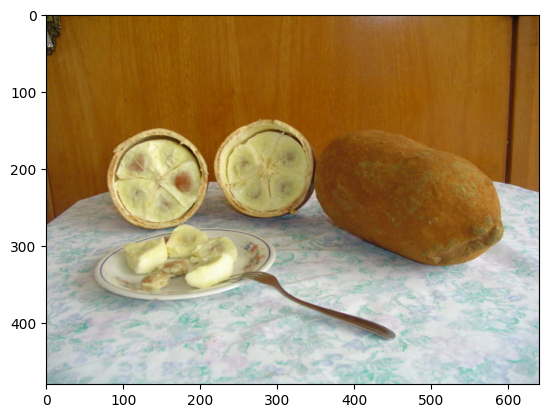

Les critaires de sélection sont :
[['SONY', 'paysage']]
image_94.JPG




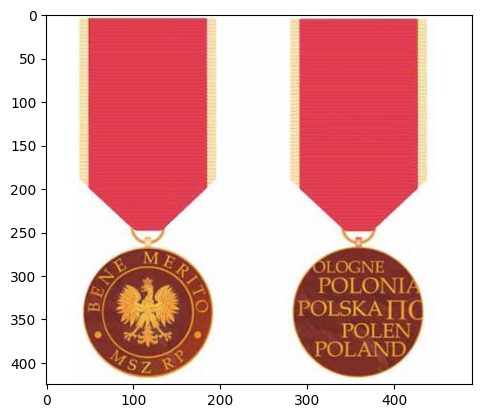

Les critaires de sélection sont :
[['paysage', 'blanc']]
image_56.jpg




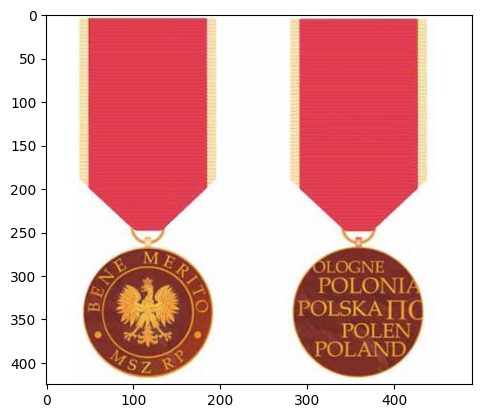

Les critaires de sélection sont :
[['paysage', 'blanc']]
image_56.jpg




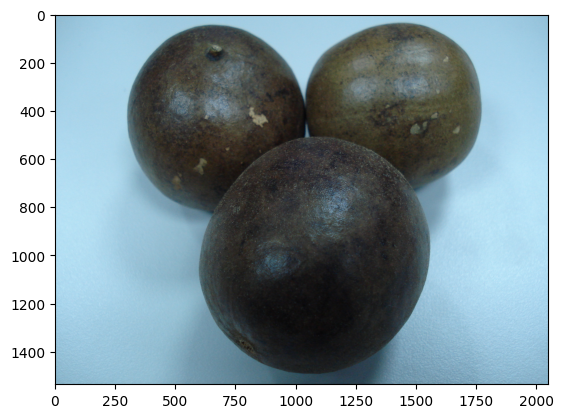

Les critaires de sélection sont :
[['SONY', 'paysage'], ['SONY', 'blanc'], ['paysage', 'blanc']]
image_91.jpg




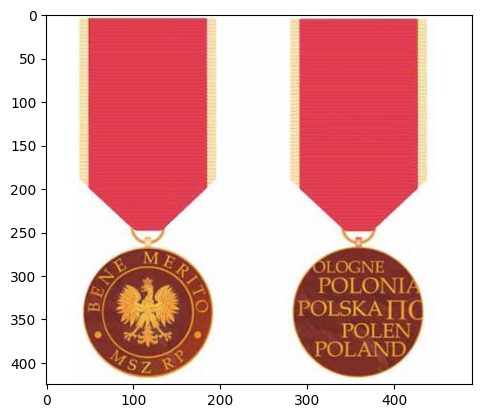

Les critaires de sélection sont :
[['paysage', 'blanc']]
image_56.jpg




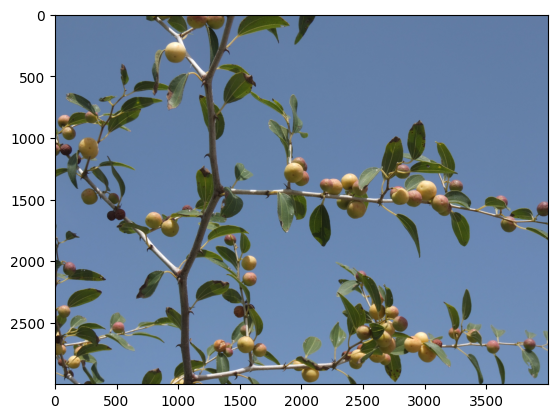

Les critaires de sélection sont :
[['paysage', 'blanc']]
image_96.jpg




In [18]:
from PIL import Image
def Recommendation(tagfav, dataframe, src):
    # Variable qui indique l'indice des photos recommandées
    nb_reco = []

    # Variables qui stock les critaires utiliser pour recommender les photos 
    cirtaire_list = []

    # Nombre de tag favoris à utiliser pour recommander la photo
    critaire = int(input("Combien de critaire voulez vous pour vos images recommender (max : 3)"))
    for i in range(len(dataframe)):

        # Un seul tag pour l'image recommandée
        if critaire == 1 :
            crit1 = []

            # Indiquation des tags favoris present sur l'image
            if dataframe["make"][i] == tagfav[0]:
                crit1.append(tagfav[0])

            if dataframe["orientation"][i] == tagfav[1] :
                print("oui")
                crit1.append(tagfav[1])

            if dataframe["couleur"][i] == tagfav[2]:
                crit1.append(tagfav[2])


            if dataframe["make"][i] == tagfav[0] or dataframe["orientation"][i] == tagfav[1] or dataframe["couleur"][i] == tagfav[2]:
                nb_reco.append(i)
                cirtaire_list.append(crit1)

        # Deux tags pour l'image recommandée
        if critaire == 2 :
            crit2 = []

            # Indiquation les couples de tags favoris présent sur l'image
            if (dataframe["make"][i] == tagfav[0] and dataframe["orientation"][i] == tagfav[1]):
                crit2.append([tagfav[0], tagfav[1]])

            if dataframe["make"][i] == tagfav[0] and dataframe["couleur"][i] == tagfav[2]:
                crit2.append([tagfav[0], tagfav[2]])

            if dataframe["couleur"][i] == tagfav[2] and dataframe["orientation"][i] == tagfav[1]:
                crit2.append([tagfav[1], tagfav[2]])


            if (dataframe["make"][i] == tagfav[0] and dataframe["orientation"][i] == tagfav[1]) or (dataframe["make"][i] == tagfav[0] and dataframe["couleur"][i] == tagfav[2]) or (dataframe["couleur"][i] == tagfav[2] and dataframe["orientation"][i] == tagfav[1]):
                nb_reco.append(i)
                cirtaire_list.append(crit2)
        
        # Trois tags pour l'image recommandée
        if critaire == 3:
            crit3 = []
            if dataframe["make"][i] == tagfav[0] and dataframe["orientation"][i] == tagfav[1] and dataframe["couleur"][i] == tagfav[2]:
                nb_reco.append(i)
                cirtaire_list.append([tagfav[0], tagfav[1], tagfav[2]])
                
    # Affichage des images recommandées
    if len(nb_reco)>0:

        # Nombre d'images à afficher dans les images recommandées
        nb_img_reco=6

        # Affichage d'image aléatoire dans le images recommandées
        for i in range(nb_img_reco):
            num_im = randint(0, len(nb_reco)-1)
            img = Image.open("images/"+src[nb_reco[num_im]])

            # Affichage de l'image
            plot.imshow(img)
            plot.show() 

            # Affichage des tags 
            print("Les critaires de sélection sont :")
            print(cirtaire_list[num_im])
            print(src[nb_reco[num_im]])
            print("\n")

Recommendation(tagfav, dataframe, src)
# Generer plusieur profile different pour voir la difference 
tagfav = loadProfile(0)
Recommendation(tagfav, dataframe, src)


# Visualisation des données

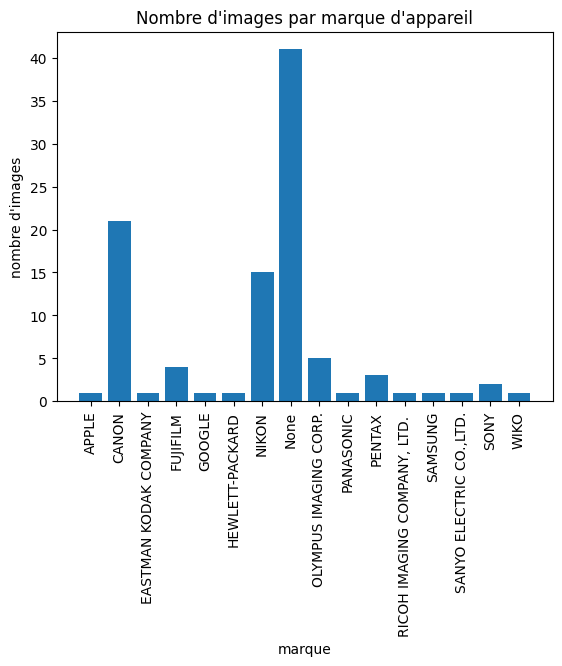

In [ ]:
import matplotlib.pyplot as plt
grouped = dataframe.groupby(["make"])["make"].count()
plt.xticks(rotation='vertical')
plt.title("Nombre d'images par marque d'appareil")
plt.xlabel("marque")
plt.ylabel("nombre d'images")
graph_bar1 = plt.bar(grouped.keys(),grouped)

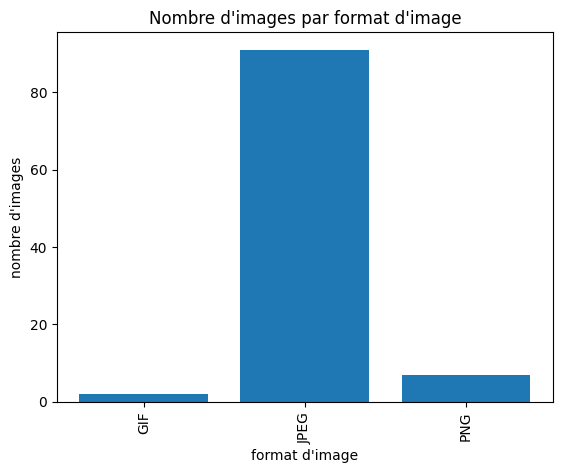

In [ ]:
grouped = dataframe.groupby(["format"])["format"].count()
plt.xticks(rotation='vertical')
plt.title("Nombre d'images par format d'image")
plt.xlabel("format d'image")
plt.ylabel("nombre d'images")
graph_bar2 = plt.bar(grouped.keys(),grouped)

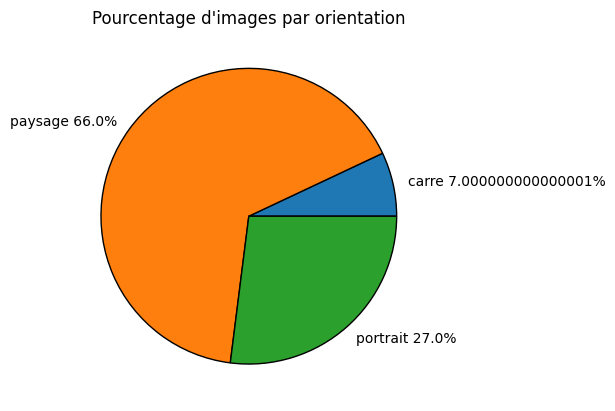

In [ ]:
grouped = dataframe.groupby(["orientation"])["orientation"].count()
percentage = [x / len(dataframe) for x in list(grouped)]
plt.title("Pourcentage d'images par orientation")
label = [orientation+" "+str(per*100)+"%" for orientation,per in zip(grouped.keys(),percentage)]
wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-', 'antialiased': True}
graph_rond = plt.pie(percentage,labels=label,wedgeprops=wedgeprops)

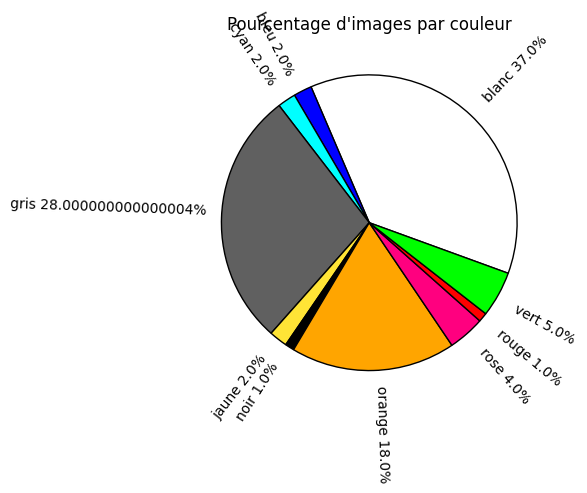

In [ ]:
grouped = dataframe.groupby(["couleur"])["couleur"].count()
percentage = [x / len(dataframe) for x in list(grouped)]
plt.title("Pourcentage d'images par couleur")
label = [col+" "+str(per*100)+"%" for col,per in zip(grouped.keys(),percentage)]
couleurs = {
            "rouge":"#FF0000",
            "orange":"#FFA500",
            "jaune":"#ffe436",
            "vert":"#00FF00",
            "cyan":"#00FFFF",
            "bleu":"#0000FF",
            "violet":"#8F00FF",
            "magenta":"#FF00FF",
            "rose":"#FF007F",
            "blanc":"#FFFFFF",
            "gris":"#606060",
            "noir":"#000000"
        }
colors=[couleurs[col] for col in grouped.keys()]
wedgeprops={"edgecolor":"k",'linewidth': 1, 'linestyle': '-', 'antialiased': True}
graph_rond_col=plt.pie(percentage,labels=label,colors=colors, wedgeprops=wedgeprops, rotatelabels =True,labeldistance=1.1, startangle = -20)